# <a id="home">Chapter 3. Classification</a>

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/03_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Table of Content:
1. [MNIST](#mnist)  
2. [Training a Binary Classifier](#training-a-binary-classifier)
3. [Performance Measures](#performance-measures)
4. [Multiclass Classification](#multiclass-classification)
5. [Error Analysis](#error-analysis)
6. [Multilabel Classification](#multilabel-classification)
7. [Multioutput Classification](#multioutput-classification)  

[Go to the end of notebook](#end)

## MNIST
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the "hello world" of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns Machine Learning tackles this dataset sooner or later.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## <a id="mnist">MNIST</a>  (Back to [home](#home))

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:   
- A `DESCR` key describing the dataset   
- A `data` key containing an array with one row per instance and one column per feature   
- A `target` key containing an array with the labels       

Let's look at these arrays:

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

There are $70,000$ images, and each image has $784$ features. This is because each image is $28 \times 28$ pixels, and each feature simply represents one pixel's intensity, from $0$ (white) to $255$ (black). Let's take a peek at one digit from the dataset. All you need to do is grab an instance's feature vector, reshape it to a $28 \times 28$ array, and display it using Matplotlib's `imshow()` function:

Saving figure some_digit_plot


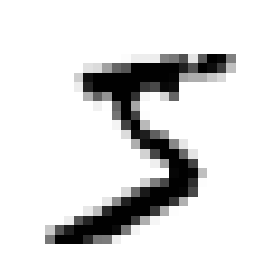

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

This looks like a 5, and indeed that's what the label tells us:

In [7]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let's cast y to integer:

In [8]:
y = y.astype(np.uint8)

In [9]:
y[0]

5

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [11]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

To give you a feel for the complexity of the classification task, Figure 3-1 shows a few more images from the MNIST dataset

Saving figure more_digits_plot


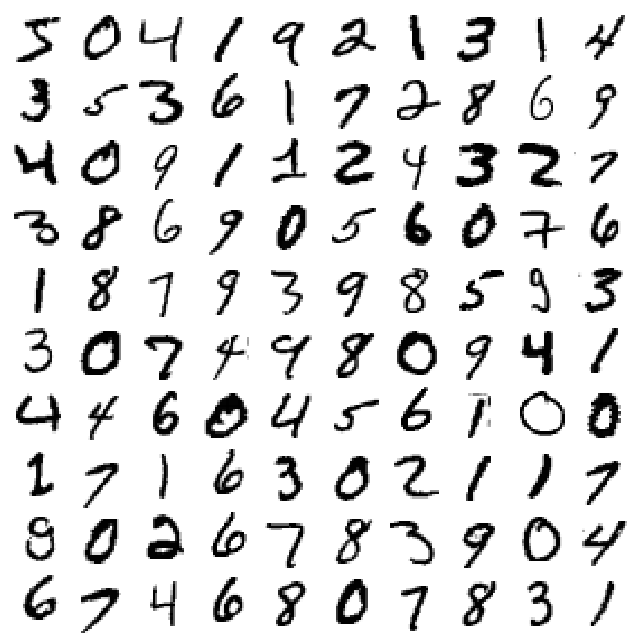

In [12]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

## <a id="training-a-binary-classifier">Training a Binary classifier</a> (Back to [Home](#home))

Let's simplify the problem for now and only try to identify one digit; for example, the number 5. This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let's create the target vectors for this classification task:

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let's pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent_ (SGD) classifier, using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let's create an `SGDClassifier` and train it on the whole training set:

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a $5$ (True). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

## <a id="performance-measures">Performance Measures</a> (Back to [Home](#home))
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!   

### Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation, just as you did in Chapter 2.    

Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):

Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function, and it prints the same result:

In [ ]:
# =========================
#    Stratified K-fold
# =========================
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

The `StratifiedKFold` class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above $93\%$ accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn't it? Well, before you get too excited, let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess this model's accuracy? Let's find out:

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That's right, it has over $90\%$ accuracy! This is simply because only about $10\%$ of the images are $5$s, so if you always guess that an image is not a $5$, you will be right about $90\%$ of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).    

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the _confusion matrix_. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of $5$s with $3$s, you would look in the fifth row and third column of the confusion matrix.    

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (`y_train_5`) and the predicted classes (`y_train_pred`):

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an _actual class_, while each column represents a predicted class. The first row of this matrix considers non-$5$ images (the negative class): $53,057$ of them were correctly classified as non-$5$s (they are called _true negatives_), while the remaining $1,522$ were wrongly classified as $5$s (_false positives_). The second row considers the images of $5$s (the _positive_ class): $1,325$ were wrongly classified as non-$5$s (_false negatives_), while the remaining $4,096$ were correctly classified as $5$s (_true positives_). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [22]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier   
$$
    \text{precision} = \frac{TP}{TP+FP}
$$

$TP$ is the number of true positives, and $FP$ is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = $1/1$ = $100\%$). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named _recall_, also called _sensitivity_ or the _true positive rate_ (TPR): this is the ratio of positive instances that are correctly detected by the classifier    
$$
    \text{recall} = \frac{TP}{TP+FN}
$$

$FN$ is, of course, the number of false negatives.    

If you are confused about the confusion matrix, Figure 3-2 may help.   
![Hello](images/Figure3-2.png)

### Precision and Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [25]:
4096 / (4096 + 1522)

0.7290850836596654

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
4096 / (4096 + 1325)

0.7555801512636044

Now your $5$-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a $5$, it is correct only $72.9\%$ of the time. Moreover, it only detects $75.6\%$ of the $5$s.

It is often convenient to combine precision and recall into a single metric called the $F_1$ score, in particular if you need a simple way to compare two classifiers. The $F_1$ score is the _harmonic mean_ of precision and recall (Equation below). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.   

$$
    F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = \cdots = \frac{TP}{TP + \frac{FN+FP}{2}}        
$$

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
4096 / (4096 + (1522 + 1325) / 2)

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only $30\%$ precision as long as it has $99\%$ recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can't have it both ways: increasing precision reduces recall, and vice versa. This is called the _precision/recall trade-off_.    

### Precision/Recall Trade-off
To understand this trade-off, let's look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Figure 3-3 shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision threshold is positioned at the central arrow (between the two $5$s): you will find $4$ true positives (actual $5$s) on the right of that threshold, and $1$ false positive (actually a $6$). Therefore, with that threshold, the precision is $80\%$ ($4$ out of $5$). But out of $6$ actual $5$s, the classifier only detects $4$, so the recall is $67\%$ ($4$ out of $6$). If you raise the threshold (move it to the arrow on the right), the false positive (the $6$) becomes a true negative, thereby increasing the precision (up to $100\%$ in this case), but one true positive becomes a false negative, decreasing recall down to $50\%$. Conversely, lowering the threshold increases recall and reduces precision.  
![hello](images/Figure3-3.png)


Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier's `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

The `SGDClassifier` uses a threshold equal to $0$, so the previous code returns the same result as the `predict()` method (i.e., `True`). Let's raise the threshold:

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

This confirms that raising the threshold decreases recall. The image actually represents a $5$, and the classifier detects it when the threshold is $0$, but it misses it when the threshold is increased to $8,000$.    

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value:

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown
save_fig("precision_recall_vs_threshold_plot")  # Not shown
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

Another way to select a good precision/recall trade-off is to plot precision directly against recall, as shown in Figure 3-5 (the same threshold as earlier is highlighted).

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

You can see that precision really starts to fall sharply around $80\%$ recall. You will probably want to select a precision/recall trade-off just before that drop; for example, at around $60\%$ recall. But of course, the choice depends on your project.

Suppose you decide to aim for $90\%$ precision. You look up the first plot and find that you need to use a threshold of about $8,000$. To be more precise you can search for the lowest threshold that gives you at least $90\%$ precision (`np.argmax()` will give you the first index of the maximum value, which in this case means the first `True` value):

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, you can run this code:

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let's check these predictions' precision and recall:

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

Great, you have a $90\%$ precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you're done. But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

## The ROC curve
The _receiver operating characteristic_ (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to $1$, the _true negative rate_ (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus $1$, specificity.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib. This code produces the plot in Figure 3-6

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to $1$, whereas a purely random classifier will have a ROC AUC equal to $0.5$. Scikit-Learn provides a function to compute the ROC AUC:

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

<div class="alert alert-block alert-info">
<b>Tip:</b> Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).
</div>

Let's now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the `RandomForestClassifier` class does not have a `decision_function()` method. Instead, it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other, or both. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image
represents a 5):

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

The `roc_curve()` function expects labels and scores, but instead of scores you can give it class probabilities. Let's use the positive class’s probability as the score:

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare (Figure 3-7):

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

As you can see in Figure 3-7, the RandomForestClassifier's ROC curve looks much better than the SGDClassifier's: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

Try measuring the precision and recall scores: you should find $99.0\%$ precision and $86.6\%$ recall. Not too bad!

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now let's try to detect more than just the 5s.

## <a id="multiclass-classification">Multiclass classification</a> (Back to [Home](#home))

#### Questions:   
1. Apakah perbedaan _one-versus-the-rest_ (OvR) dan _one-versus-one_ (OvO)?
2. Apabila terdapat 10 kelas, berapakah _binary classifier_ yang diperlukan dalam strategi _one-versus-one_ (OvO)?

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the `sklearn.svm.SVC` class:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

That was easy! This code trains the `SVC` on the training set using the original target classes from 0 to 9 (`y_train`), instead of the 5-versus-the-rest target classes (`y_train_5`). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.    
    
If you call the `decision_function()` method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class:

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

The highest score is indeed the one corresponding to class 5 :

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

<div class="alert alert-block alert-warning">
<b>Warning:</b> When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5 ), but in general you won't be so lucky.
</div>

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

Training an `SGDClassifier` (or a `RandomForestClassifier`) is just as easy:

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes. The `decision_function()` method now returns one value per class. Let's look at the score that the SGD classifier assigned to each class:

In [ ]:
sgd_clf.decision_function([some_digit])

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of $2412.5$. The model has a slight doubt regarding class 3 , which gets a score of $573.5$. Now of course you want to evaluate this classifier. As usual, you can use cross-validation. Use the `cross_val_score()` function to evaluate the `SGDClassifier`'s accuracy:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over $84\%$ on all test folds. If you used a random classifier, you would get `10%` accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above $89\%$:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## <a id="error-analysis">Error Analysis</a> (Back to [Home](#home))
If this were a real project, you would now follow the steps in your Machine Learning project checklist (see Appendix B). You'd explore data preparation options, try out multiple models (shortlisting the best ones and
fine-tuning their hyperparameters using `GridSearchCV` ), and automate as much as possible. Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.   
   
First, look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function, just like you did earlier:

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

That's a lot of numbers. It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's `matshow()` function:

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.   
   
Let's focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors
(which would make abundant classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

You can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predictedclasses. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).    
   
Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.    
   
Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let’s plot examples of 3s and 5s (the `plot_digits()` function just uses Matplotlib's `imshow()` function; see this chapter's Jupyter notebook for details):

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

The two $5 \times 5$ blocks on the left show digits classified as 3s, and the two $5 \times 5$ blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 in the first row and second column truly looks like a badly written 3). However, most misclassified images seem like obvious errors to us, and it's hard to understand why the classifier made the mistakes it did. 3 The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.     
    
The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

## <a id="multilabel-classification">Multilabel classification</a> (Back to [Home](#home))

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning "Alice yes, Bob no, Charlie yes"). Such a classification system that outputs multiple binary tags is called a multilabel classification system.   
   
We won't go into face recognition just yet, but let's look at a simpler example, just for illustration purposes:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

This code creates a `y_multilabel` array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8,or 9), and the second indicates whether or not it is odd. The next lines create a `KNeighborsClassifier` instance (which supports multilabel classification, though not all classifiers do), and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [ ]:
knn_clf.predict([some_digit])

And it gets it right! The digit 5 is indeed not large (`False`) and odd (`True`). There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure
the $F_1$ score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average $F_1$ score across all labels:

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set `average="weighted"` in the preceding code.

## <a id="multioutput-classification">Multioutput classification</a> (Back to [Home](#home))
The last type of classification task we are going to discuss here is called _multioutput_ ; _multiclass classification_ (or simply _multioutput classification_). It is simply a generalization of multilabel classification
where each label can be multiclass (i.e., it can have more than two possible values).    
   
To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification
system.   
   
Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy's `randint()` function. The target images will be the original images:

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's take a peek at an image from the test set (yes, we're snooping on the test data, so you should be frowning right now):

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let's train the classifier and make it clean this image:

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

Looks close enough to the target! This concludes our tour of classification. You should now know how to select good metrics for classification tasks, pick the appropriate precision/recall trade-off, compare classifiers, and more generally build good classification systems for a variety of tasks.

# Extra material

## Dummy (ie. random) classifier

In [ ]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

In [ ]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

In [ ]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

## <a id="end">The End</a> (Back to [Home](#home))